Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import rdflib
from rdflib import Graph, Literal, Namespace, RDF, URIRef, OWL
from rdflib.extras.external_graph_libs import rdflib_to_networkx_digraph
from rdflib.namespace import DC, FOAF

from owlready2 import *
from owlready2 import get_ontology

from sklearn.model_selection import train_test_split

import networkx as nx
import networkx.algorithms.community as nx_comm

random.seed(10)

Loading the original data

In [2]:
data = pd.read_excel('/Users/ninaliem/Downloads/opioids_data_original.xlsx')
side_effects = pd.read_excel("/Users/ninaliem/Downloads/KRW_assign1-main/sider_output3.xlsx")
frequencies = pd.read_csv('meddra_freq.tsv', sep='\t', header=None)

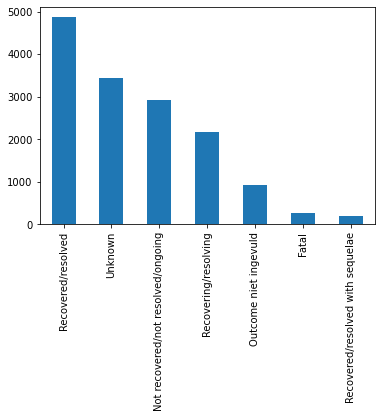

In [3]:
data.Outcome.value_counts().plot(kind='bar');

In [4]:
data['Outcome'].value_counts(normalize=True) * 100

Recovered/resolved                    32.909681
Unknown                               23.201731
Not recovered/not resolved/ongoing    19.808004
Recovering/resolving                  14.663332
Outcome niet ingevuld                  6.280422
Fatal                                  1.852353
Recovered/resolved with sequelae       1.284478
Name: Outcome, dtype: float64

Changing the 'Outcome' column values and removing the 'Unknown' values

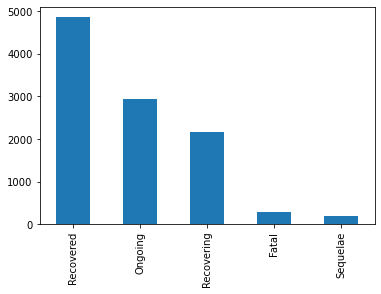

In [5]:
data['Outcome'] = data['Outcome'].replace(['Outcome niet ingevuld', 'Recovered/resolved', 'Not recovered/not resolved/ongoing', 'Recovered/resolved with sequelae', 'Recovering/resolving'], ['Unknown', 'Recovered', 'Ongoing', 'Sequelae', 'Recovering'])
data = data[data['Outcome'] != 'Unknown']
data.Outcome.value_counts().plot(kind='bar');

In [6]:
data['Outcome'].value_counts(normalize=True) * 100

Recovered     46.668584
Ongoing       28.089349
Recovering    20.793788
Fatal          2.626786
Sequelae       1.821494
Name: Outcome, dtype: float64

**DROP COLUMNS**

In [7]:
data = data.drop(columns=['Primary Source Description', 'Status', 'Category', 'OutcomeCodeSystemVersion', 'OutcomeText', 'CultureID', 'date_received', 'summary', 'narrative', 'IsCurrent', 'IsDefaultSOC'])

**REMOVE OUTLIERS**

- Removal of instances with bodyweight == 0 or 500
- Removal of instances shorter than 150 and taller than 200
- Removal of instances younger than 18 and older than 90

In [8]:
data = data[data.BodyWeight != 0] 

**CLEANING**

tramadol met paracetamol; N02AJ13 --> N02AX02
oxy met nalo; N02AA55 --> N02AA05
morf combi; N02AA51 --> N02AA01

In [9]:
data['ATCText'].replace(['TRAMADOL MET PARACETAMOL', 'OXYCODON MET NALOXON', 'MORFINE, COMBINATIEPREPARATEN'], ['TRAMADOL', 'OXYCODON', 'MORFINE'], inplace=True)

data['ATCode'].replace(['N02AJ13', 'N02AA51'], ['N02AX02', 'N02AA01'], inplace=True)

data['ATCText'] = data['ATCText'].str.lower()

**MERGING**

In [10]:
data = data.merge(side_effects[['ATCode', 'ATCText', 'PTCode', 'Side effect', 'Frequency']], how='left', on=['ATCode', 'ATCText', 'PTCode'])

The 'reaction_impact' column presumably measures the impact the medicine has had on the patient. As shown before, there is no reaction_impact for fatalities. 
We can impute the missing values by taking the average of a patient with similar features. 

To make this easier, we'll first create a column to bin the ages. We'll also create a BMI column and a weight group column.

In [11]:
data['age_group'] = pd.cut(x=data['age_year'], bins=[18, 24, 44, 64, 90])

data['BMI'] = data['BodyWeight'] / (data['Height']/100)**2

data['weight_group'] = pd.cut(x=data['BMI'], bins=[0, 18.5, 25, 30, 50], labels=['underweight', 'normal', 'overweight', 'obese'])

Filling the missing reaction_impact values with averages based on patient characteristics/medicine taken/outcome:

In [12]:
data['reaction_impact'] = data['reaction_impact'].fillna(data.groupby(['sex', 'age_group', 'weight_group', 'Outcome', 'ATCText'])['reaction_impact'].transform('mean'))
data['reaction_impact'] = data['reaction_impact'].fillna(data.groupby(['sex', 'Outcome', 'ATCText'])['reaction_impact'].transform('mean'))
data['reaction_impact'] = data['reaction_impact'].fillna(data.groupby(['Outcome'])['reaction_impact'].transform('mean'))

In [13]:
data = data[data['weight_group'].notna()]

**DROP NA**

In [14]:
data['Frequency'] = data['Frequency'] * 100

In [15]:
data.reset_index(drop=True)

,WorldwideUniqueCaseIdentification,BodyWeight,Height,sex,age_year,Outcome,reaction_impact,ATCText,ATCode,GenericDrugName,...,HLTGCode,HLTGName,SOCCode,SOCName,SOCAbbreviation,Side effect,Frequency,age_group,BMI,weight_group
0,NL-002147023-NVSC2020NL143475,67.0,160.0,female,80.0,Sequelae,2.00,tramadol,N02AX02,TRAMADOL HYDROCHLORIDE,...,10012221,Deliria (incl confusion),10037175,Psychiatric disorders,Psych,Delirium,0.1,"(64, 90]",26.171875,overweight
1,NL-002147023-NVSC2020NL143475,67.0,160.0,female,80.0,Sequelae,2.00,tramadol,N02AX02,TRAMADOL HYDROCHLORIDE,...,10047438,Viral infectious disorders,10021881,Infections and infestations,Infec,NaN,NaN,"(64, 90]",26.171875,overweight
2,NL-002147023-NVSC2020NL223553,84.0,170.0,female,67.0,Recovered,4.00,tramadol,N02AX02,TRAMADOL HYDROCHLORIDE,...,10016950,Food intolerance syndromes,10027433,Metabolism and nutrition disorders,Metab,NaN,NaN,"(64, 90]",29.065744,overweight
3,NL-002147023-NVSC2020NL223553,84.0,170.0,female,67.0,Recovered,4.00,tramadol,N02AX02,TRAMADOL HYDROCHLORIDE,...,10003816,Autoimmune disorders,10021428,Immune system disorders,Immun,NaN,NaN,"(64, 90]",29.065744,overweight
4,NL-002147023-NVSC2020NL223553,84.0,170.0,female,67.0,Recovered,4.00,tramadol,N02AX02,TRAMADOL HYDROCHLORIDE,...,10016950,Food intolerance syndromes,10027433,Metabolism and nutrition disorders,Metab,NaN,NaN,"(64, 90]",29.065744,overweight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6197,NL-TEVA-719924ROM,70.0,178.0,male,74.0,Recovered,4.75,oxycodon,N02AA05,OXYCODON TABLET 5MG,...,10005908,Body temperature conditions,10018065,General disorders and administration site cond...,Genrl,NaN,NaN,"(64, 90]",22.093170,normal
6198,NL-TEVA-719924ROM,70.0,178.0,male,74.0,Recovered,4.75,oxycodon,N02AA05,OXYCODON TABLET 5MG,...,10024970,Respiratory tract infections,10038738,"Respiratory, thoracic and mediastinal disorders",Resp,NaN,NaN,"(64, 90]",22.093170,normal
6199,NL-TEVA-719924ROM,70.0,178.0,male,74.0,Recovered,4.75,oxycodon,N02AA05,OXYCODON TABLET 5MG,...,10005959,Bone disorders (excl congenital and fractures),10028395,Musculoskeletal and connective tissue disorders,Musc,NaN,NaN,"(64, 90]",22.093170,normal
6200,NL-TEVA-719924ROM,70.0,178.0,male,74.0,Recovered,4.75,oxycodon,N02AA05,OXYCODON TABLET 5MG,...,10018188,Genitourinary tract disorders NEC,10038359,Renal and urinary disorders,Renal,NaN,NaN,"(64, 90]",22.093170,normal


In [16]:
data_ = data
#data_[data_['Frequency'] == 0.0] = 0.0001
data_['Frequency'] = data_['Frequency'].replace(0.0, 0.0001)
data_['Frequency'] = data_['Frequency'].fillna(0.0)

data_['is_sideeffect'] = data_['Side effect'].notna()
data_['Side effect'] = data_['Side effect'].fillna('Unknown')

In [17]:
data_

,WorldwideUniqueCaseIdentification,BodyWeight,Height,sex,age_year,Outcome,reaction_impact,ATCText,ATCode,GenericDrugName,...,HLTGName,SOCCode,SOCName,SOCAbbreviation,Side effect,Frequency,age_group,BMI,weight_group,is_sideeffect
10,NL-002147023-NVSC2020NL143475,67.0,160.0,female,80.0,Sequelae,2.00,tramadol,N02AX02,TRAMADOL HYDROCHLORIDE,...,Deliria (incl confusion),10037175,Psychiatric disorders,Psych,Delirium,0.1,"(64, 90]",26.171875,overweight,True
11,NL-002147023-NVSC2020NL143475,67.0,160.0,female,80.0,Sequelae,2.00,tramadol,N02AX02,TRAMADOL HYDROCHLORIDE,...,Viral infectious disorders,10021881,Infections and infestations,Infec,Unknown,0.0,"(64, 90]",26.171875,overweight,False
12,NL-002147023-NVSC2020NL223553,84.0,170.0,female,67.0,Recovered,4.00,tramadol,N02AX02,TRAMADOL HYDROCHLORIDE,...,Food intolerance syndromes,10027433,Metabolism and nutrition disorders,Metab,Unknown,0.0,"(64, 90]",29.065744,overweight,False
13,NL-002147023-NVSC2020NL223553,84.0,170.0,female,67.0,Recovered,4.00,tramadol,N02AX02,TRAMADOL HYDROCHLORIDE,...,Autoimmune disorders,10021428,Immune system disorders,Immun,Unknown,0.0,"(64, 90]",29.065744,overweight,False
14,NL-002147023-NVSC2020NL223553,84.0,170.0,female,67.0,Recovered,4.00,tramadol,N02AX02,TRAMADOL HYDROCHLORIDE,...,Food intolerance syndromes,10027433,Metabolism and nutrition disorders,Metab,Unknown,0.0,"(64, 90]",29.065744,overweight,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10312,NL-TEVA-719924ROM,70.0,178.0,male,74.0,Recovered,4.75,oxycodon,N02AA05,OXYCODON TABLET 5MG,...,Body temperature conditions,10018065,General disorders and administration site cond...,Genrl,Unknown,0.0,"(64, 90]",22.093170,normal,False
10313,NL-TEVA-719924ROM,70.0,178.0,male,74.0,Recovered,4.75,oxycodon,N02AA05,OXYCODON TABLET 5MG,...,Respiratory tract infections,10038738,"Respiratory, thoracic and mediastinal disorders",Resp,Unknown,0.0,"(64, 90]",22.093170,normal,False
10314,NL-TEVA-719924ROM,70.0,178.0,male,74.0,Recovered,4.75,oxycodon,N02AA05,OXYCODON TABLET 5MG,...,Bone disorders (excl congenital and fractures),10028395,Musculoskeletal and connective tissue disorders,Musc,Unknown,0.0,"(64, 90]",22.093170,normal,False
10315,NL-TEVA-719924ROM,70.0,178.0,male,74.0,Recovered,4.75,oxycodon,N02AA05,OXYCODON TABLET 5MG,...,Genitourinary tract disorders NEC,10038359,Renal and urinary disorders,Renal,Unknown,0.0,"(64, 90]",22.093170,normal,False


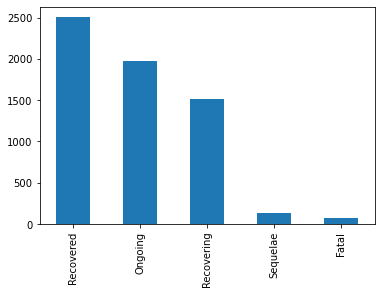

In [18]:
data_.Outcome.value_counts().plot(kind='bar');

In [19]:
data_ = data_.drop_duplicates()
data_

,WorldwideUniqueCaseIdentification,BodyWeight,Height,sex,age_year,Outcome,reaction_impact,ATCText,ATCode,GenericDrugName,...,HLTGName,SOCCode,SOCName,SOCAbbreviation,Side effect,Frequency,age_group,BMI,weight_group,is_sideeffect
10,NL-002147023-NVSC2020NL143475,67.0,160.0,female,80.0,Sequelae,2.00,tramadol,N02AX02,TRAMADOL HYDROCHLORIDE,...,Deliria (incl confusion),10037175,Psychiatric disorders,Psych,Delirium,0.1,"(64, 90]",26.171875,overweight,True
11,NL-002147023-NVSC2020NL143475,67.0,160.0,female,80.0,Sequelae,2.00,tramadol,N02AX02,TRAMADOL HYDROCHLORIDE,...,Viral infectious disorders,10021881,Infections and infestations,Infec,Unknown,0.0,"(64, 90]",26.171875,overweight,False
12,NL-002147023-NVSC2020NL223553,84.0,170.0,female,67.0,Recovered,4.00,tramadol,N02AX02,TRAMADOL HYDROCHLORIDE,...,Food intolerance syndromes,10027433,Metabolism and nutrition disorders,Metab,Unknown,0.0,"(64, 90]",29.065744,overweight,False
13,NL-002147023-NVSC2020NL223553,84.0,170.0,female,67.0,Recovered,4.00,tramadol,N02AX02,TRAMADOL HYDROCHLORIDE,...,Autoimmune disorders,10021428,Immune system disorders,Immun,Unknown,0.0,"(64, 90]",29.065744,overweight,False
14,NL-002147023-NVSC2020NL223553,84.0,170.0,female,67.0,Recovered,4.00,tramadol,N02AX02,TRAMADOL HYDROCHLORIDE,...,Food intolerance syndromes,10027433,Metabolism and nutrition disorders,Metab,Unknown,0.0,"(64, 90]",29.065744,overweight,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10312,NL-TEVA-719924ROM,70.0,178.0,male,74.0,Recovered,4.75,oxycodon,N02AA05,OXYCODON TABLET 5MG,...,Body temperature conditions,10018065,General disorders and administration site cond...,Genrl,Unknown,0.0,"(64, 90]",22.093170,normal,False
10313,NL-TEVA-719924ROM,70.0,178.0,male,74.0,Recovered,4.75,oxycodon,N02AA05,OXYCODON TABLET 5MG,...,Respiratory tract infections,10038738,"Respiratory, thoracic and mediastinal disorders",Resp,Unknown,0.0,"(64, 90]",22.093170,normal,False
10314,NL-TEVA-719924ROM,70.0,178.0,male,74.0,Recovered,4.75,oxycodon,N02AA05,OXYCODON TABLET 5MG,...,Bone disorders (excl congenital and fractures),10028395,Musculoskeletal and connective tissue disorders,Musc,Unknown,0.0,"(64, 90]",22.093170,normal,False
10315,NL-TEVA-719924ROM,70.0,178.0,male,74.0,Recovered,4.75,oxycodon,N02AA05,OXYCODON TABLET 5MG,...,Genitourinary tract disorders NEC,10038359,Renal and urinary disorders,Renal,Unknown,0.0,"(64, 90]",22.093170,normal,False


In [20]:
data_ = data_.reset_index(drop=True)

In [21]:
data_.to_excel("opioid_data_merged.xlsx") 

In [22]:
data_

,WorldwideUniqueCaseIdentification,BodyWeight,Height,sex,age_year,Outcome,reaction_impact,ATCText,ATCode,GenericDrugName,...,HLTGName,SOCCode,SOCName,SOCAbbreviation,Side effect,Frequency,age_group,BMI,weight_group,is_sideeffect
0,NL-002147023-NVSC2020NL143475,67.0,160.0,female,80.0,Sequelae,2.00,tramadol,N02AX02,TRAMADOL HYDROCHLORIDE,...,Deliria (incl confusion),10037175,Psychiatric disorders,Psych,Delirium,0.1,"(64, 90]",26.171875,overweight,True
1,NL-002147023-NVSC2020NL143475,67.0,160.0,female,80.0,Sequelae,2.00,tramadol,N02AX02,TRAMADOL HYDROCHLORIDE,...,Viral infectious disorders,10021881,Infections and infestations,Infec,Unknown,0.0,"(64, 90]",26.171875,overweight,False
2,NL-002147023-NVSC2020NL223553,84.0,170.0,female,67.0,Recovered,4.00,tramadol,N02AX02,TRAMADOL HYDROCHLORIDE,...,Food intolerance syndromes,10027433,Metabolism and nutrition disorders,Metab,Unknown,0.0,"(64, 90]",29.065744,overweight,False
3,NL-002147023-NVSC2020NL223553,84.0,170.0,female,67.0,Recovered,4.00,tramadol,N02AX02,TRAMADOL HYDROCHLORIDE,...,Autoimmune disorders,10021428,Immune system disorders,Immun,Unknown,0.0,"(64, 90]",29.065744,overweight,False
4,NL-002147023-NVSC2020NL223553,84.0,170.0,female,67.0,Recovered,4.00,tramadol,N02AX02,TRAMADOL HYDROCHLORIDE,...,Food intolerance syndromes,10027433,Metabolism and nutrition disorders,Metab,Unknown,0.0,"(64, 90]",29.065744,overweight,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6192,NL-TEVA-719924ROM,70.0,178.0,male,74.0,Recovered,4.75,oxycodon,N02AA05,OXYCODON TABLET 5MG,...,Body temperature conditions,10018065,General disorders and administration site cond...,Genrl,Unknown,0.0,"(64, 90]",22.093170,normal,False
6193,NL-TEVA-719924ROM,70.0,178.0,male,74.0,Recovered,4.75,oxycodon,N02AA05,OXYCODON TABLET 5MG,...,Respiratory tract infections,10038738,"Respiratory, thoracic and mediastinal disorders",Resp,Unknown,0.0,"(64, 90]",22.093170,normal,False
6194,NL-TEVA-719924ROM,70.0,178.0,male,74.0,Recovered,4.75,oxycodon,N02AA05,OXYCODON TABLET 5MG,...,Bone disorders (excl congenital and fractures),10028395,Musculoskeletal and connective tissue disorders,Musc,Unknown,0.0,"(64, 90]",22.093170,normal,False
6195,NL-TEVA-719924ROM,70.0,178.0,male,74.0,Recovered,4.75,oxycodon,N02AA05,OXYCODON TABLET 5MG,...,Genitourinary tract disorders NEC,10038359,Renal and urinary disorders,Renal,Unknown,0.0,"(64, 90]",22.093170,normal,False


In [23]:
onto = get_ontology("http://example.org/medsur.owl")

class Patients(Thing):
    namespace = onto

class AgeGroup(Thing):
    namespace = onto
 
class hasAgeGroup(ObjectProperty):                  # TODO: do we need to define ranges for our properties?
    domain = [Patients]
    range = [AgeGroup]
    namespace = onto
  
class WeightGroup(Thing):
    namespace = onto
    
class hasWeightGroup(ObjectProperty):   # is this range correct if we connect patient directly to weightgroup is rdf tripple, else delete range
    domain = [Patients]
    range = [WeightGroup]
    namespace = onto
    
class Symptoms(Thing):
    namespace = onto
    
class hasSymptom(ObjectProperty):
    domain = [Patients]
    range = [Symptoms]
    namespace = onto

class Outcome(Thing):
    namespace = onto
    
class hasOutcome(ObjectProperty):
    domain = [Patients]
    range = [Outcome]
    namespace = onto
    
class Gender(Thing):
    namespace = onto

class hasGender(ObjectProperty):
    domain = [Patients]
    range = [Gender]
    namespace = onto

class Drug(Thing):
    namespace = onto
    
class IsGivenDrug(ObjectProperty):
    domain = [Patients]
    range = [Drug]
    namespace = onto
    
class IsOfDosis(ObjectProperty):
    domain = [Drug]
    namespace = onto
    
class IsOfType(ObjectProperty):
    domain = [Drug]
    namespace = onto

class SideEffects(Thing):
    namespace = onto
    
class hasSideEffect(ObjectProperty):
    domain = [Drug]
    range = [SideEffects]
    namespace = onto
    
class hasFrequency(ObjectProperty):                 
    domain = [SideEffects]
    namespace = onto 

In [24]:
onto.save(file = "medsur.rdf", format = "rdfxml") 
g = rdflib.Graph()
g.parse("medsur.rdf", format="xml")

# Loop through each triple in the graph (subj, pred, obj)
for subj, pred, obj in g:
    
    # Check if there is at least one triple in the Graph
    if (subj, pred, obj) not in g:
       raise Exception("It better be!")

# Print the number of "triples" in the Graph
print(f"Graph g has {len(g)} statements.")

Graph g has 44 statements.


In [25]:
# print all the triples in the graph 
for s, p, o in g:
    print(s, p, o)

http://example.org/medsur.owl#hasOutcome http://www.w3.org/2000/01/rdf-schema#domain http://example.org/medsur.owl#Patients
http://example.org/medsur.owl#hasSideEffect http://www.w3.org/2000/01/rdf-schema#range http://example.org/medsur.owl#SideEffects
http://example.org/medsur.owl#Gender http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#Class
http://example.org/medsur.owl#SideEffects http://www.w3.org/2000/01/rdf-schema#subClassOf http://www.w3.org/2002/07/owl#Thing
http://example.org/medsur.owl http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#Ontology
http://example.org/medsur.owl#AgeGroup http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#Class
http://example.org/medsur.owl#Outcome http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#Class
http://example.org/medsur.owl#hasSymptom http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#ObjectProperty
http

In [26]:
data_['WorldwideUniqueCaseIdentification'] = data_['WorldwideUniqueCaseIdentification'].astype(str)
data_['age_group'] = data_['age_group'].astype(str)
data_['PTCode'] = data_['PTCode'].astype(str)

In [27]:
# add RDF triples to the ontology
EX = rdflib.Namespace("http://example.org/medsur.rdf#")

for index, row in data_.iterrows():

    patient = URIRef(f"http://www.medsur.org/patient_{row['WorldwideUniqueCaseIdentification']}")
    g.add((patient, RDF.type, EX.Patients))

    weight_group = URIRef(f"http://www.medsur.org/weight/{row['weight_group']}")
    g.add((weight_group, RDF.type, EX.WeightGroup))
    g.add((patient, EX.hasWeightGroup, weight_group))

    # age_group = URIRef(f"http://www.medsur.org/age/{row['age_group']}")
    # g.add((age_group, RDF.type, EX.AgeGroup))
    # g.add((patient, EX.hasAgeGroup, age_group))
    if float(row["age_year"]) >= 65:
        agegroup = URIRef("http://www.medsur.org/age/65_above")
    elif float(row["age_year"]) >= 45:
        agegroup = URIRef("http://www.medsur.org/age/45_64") 
    elif float(row["age_year"]) >= 25:
        agegroup = URIRef("http://www.medsur.org/age/25_44")
    elif float(row["age_year"]) >= 18:
        agegroup = URIRef("http://www.medsur.org/age/18_24")
    
    g.add((agegroup, RDF.type, EX.AgeGroup))
    g.add((patient, EX.hasAgeGroup, agegroup))

    gender = URIRef(f"http://www.medsur.org/gender/{row['sex']}")
    g.add((gender, RDF.type, EX.Gender))
    g.add((patient, EX.hasGender, gender))

    outcome = URIRef(f"http://www.medsur.org/outcome/{row['Outcome']}")
    g.add((outcome, RDF.type, EX.Outcome))
    g.add((patient, EX.hasOutcome, outcome))

    symptom = URIRef(f"http://www.medsur.org/symptom/{row['PTCode']}")
    g.add((symptom, RDF.type, EX.Symptoms))
    g.add((patient, EX.hasSymptom, symptom))

    drug = URIRef(f"http://www.medsur.org/drug/{row['ATCode']}")              
    g.add((drug, RDF.type, EX.Drug))   
    g.add((patient, EX.isGivenDrug, drug))

    if row['is_sideeffect'] == True:
        side_effect = URIRef(f"http://www.medsur.org/side_effect/{row['PTCode']}")
        g.add((side_effect, RDF.type, EX.SideEffects))
        g.add((drug, EX.hasSideEffect, side_effect))

    g.add((side_effect, EX.hasFrequency, Literal(row['Frequency'])))

http://www.medsur.org/patient_NL-PFIZER INC-2010010779 does not look like a valid URI, trying to serialize this will break.
http://www.medsur.org/patient_NL-PFIZER INC-2010010779 does not look like a valid URI, trying to serialize this will break.
http://www.medsur.org/patient_NL-PFIZER INC-2010010779 does not look like a valid URI, trying to serialize this will break.
http://www.medsur.org/patient_NL-PFIZER INC-2010010779 does not look like a valid URI, trying to serialize this will break.
http://www.medsur.org/patient_NL-PFIZER INC-2010010779 does not look like a valid URI, trying to serialize this will break.
http://www.medsur.org/patient_NL-PFIZER INC-2010010779 does not look like a valid URI, trying to serialize this will break.
http://www.medsur.org/patient_NL-PFIZER INC-2012205796 does not look like a valid URI, trying to serialize this will break.
http://www.medsur.org/patient_NL-PFIZER INC-2012205796 does not look like a valid URI, trying to serialize this will break.
http://w

In [28]:
nx_graph = rdflib_to_networkx_digraph(g)
print("Number of Nodes: {n}".format(n=nx.number_of_nodes(nx_graph)))
print("Number of Edges: {n}".format(n=nx.number_of_edges(nx_graph)))
print("Density of Graph: {n}".format(n=nx.density(nx_graph)))
print("Clustering coefficient: {n}".format(n=nx.average_clustering(nx_graph)))
print("Degree centrality:", nx.degree_centrality(nx_graph))

Number of Nodes: 2516
Number of Edges: 15089
Density of Graph: 0.0023845796445492386
Clustering coefficient: 0.0
Degree centrality: {rdflib.term.URIRef('http://www.medsur.org/patient_NL-LRB-205838'): 0.002783300198807157, rdflib.term.URIRef('http://www.medsur.org/outcome/Recovered'): 0.2858846918489066, rdflib.term.URIRef('http://www.medsur.org/patient_NL-LRB-76036'): 0.005566600397614314, rdflib.term.URIRef('http://www.medsur.org/symptom/10044565'): 0.01510934393638171, rdflib.term.URIRef('http://www.medsur.org/patient_NL-LRB-00399987'): 0.002783300198807157, rdflib.term.URIRef('http://www.medsur.org/drug/N02AA01'): 0.050894632206759445, rdflib.term.URIRef('http://www.medsur.org/patient_NL-ELI_LILLY_AND_COMPANY-NL201812006871'): 0.0035785288270377734, rdflib.term.URIRef('http://www.medsur.org/patient_NL-LRB-00276708'): 0.00437375745526839, rdflib.term.URIRef('http://www.medsur.org/symptom/10022004'): 0.002783300198807157, rdflib.term.URIRef('http://www.medsur.org/patient_NL-LRB-004208

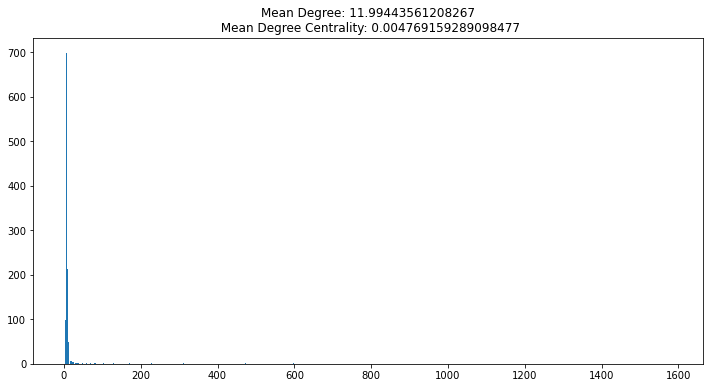

In [29]:
histdegree = pd.DataFrame(nx.degree_histogram(nx_graph))
degree = dict(nx.degree(nx_graph))

mean_degree = np.mean(list(degree.values()))
mean_degree_centrality = np.mean(list(nx.degree_centrality(nx_graph).values()))

fig, ax = plt.subplots(figsize=(12,6)) 
ax.bar(histdegree.index.values,histdegree[0])

plt.title("Mean Degree: {n1}\n Mean Degree Centrality: {n2}".format(n1=mean_degree,n2=mean_degree_centrality))
plt.show()

In [30]:
def find_blanknodes(g):
    blank_nodes = []
    BNode = rdflib.term.BNode
    for s, p, o in g:
        if isinstance(s, BNode):
            blank_nodes.append(s)
        if isinstance(o, BNode):
            blank_nodes.append(o)
    return blank_nodes 

print("Number of Blank Nodes: {n}".format(n=len(find_blanknodes(g))))

Number of Blank Nodes: 0


Number of found communitites 340 
 Number of nodes in the graph 2508
0th community: 
 {'http://www.medsur.org/patient_NL-LRB-00376318', 'http://www.medsur.org/patient_NL-LRB-00348557', 'http://www.medsur.org/patient_NL-LRB-00295490', 'http://www.medsur.org/symptom/10044565', 'http://www.medsur.org/patient_NL-LRB-00251458'}
1th community: 
 {'http://www.medsur.org/patient_NL-LRB-212094', 'http://www.medsur.org/symptom/10016334', 'http://www.medsur.org/patient_NL-LRB-00409980'}
2th community: 
 {'http://www.medsur.org/patient_NL-LRB-112569', 'http://www.medsur.org/patient_NL-LRB-00281745', 'http://www.medsur.org/patient_NL-ELI_LILLY_AND_COMPANY-NL201905008533', 'http://www.medsur.org/symptom/10028411', 'http://www.medsur.org/patient_NL-LRB-00361685'}
3th community: 
 {'http://www.medsur.org/symptom/10044390', 'http://www.medsur.org/patient_NL-LRB-85999'}
4th community: 
 {'http://www.medsur.org/patient_NL-LRB-00401775', 'http://www.medsur.org/symptom/10023230'}
5th community: 
 {'http://

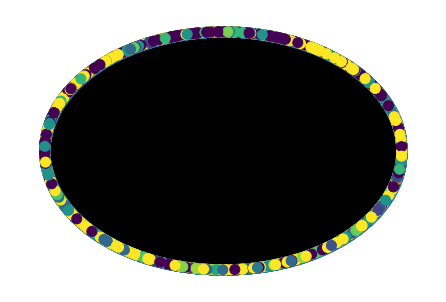

In [31]:

def clustering_louvain(nx_graph):
    
    mapping = pd.DataFrame(nx_graph.nodes())
    mapping['new_names'] = mapping[0].str.split("#",n=1,expand=False)
    mapping['label'] = 'NA'

    mapping_copy = mapping.copy()

    for ind, m in mapping_copy.iterrows():
        l = len(m['new_names'])
        names = m['new_names']
        mapping.loc[ind,'label'] = names[l-1]

    map_dict = dict(zip(mapping[0],mapping['label']))
    nx_graph_nl = nx.relabel_nodes(nx_graph, map_dict,copy=True)
    communities = nx_comm.louvain_communities(nx_graph_nl,resolution=1)
    print('Number of found communitites', len(communities),
    '\n Number of nodes in the graph',nx.number_of_nodes(nx_graph_nl))
    for i in range(len(communities)):
        print(f'{i}th community: \n',communities[i] )
        

    pos = nx.shell_layout(nx_graph_nl)
    nx.draw(nx_graph_nl, pos, edge_color='k',font_weight='light', 
            node_size= 100, width= 0.8)

    for com in communities:
        nx.draw_networkx_nodes(nx_graph_nl,
                            pos,
                            nodelist=com, 
                            #node_color=np.random.rand(3,),
                            node_color = range(len(com)),
                            label=True,
                            node_size=100)   
    return

clustering_louvain(nx_graph) 
